# Bertrand Paradox

Given a circle and an inscribed equilateral triangle, what is the probability that the length of a random chord is greater than the side of the triangle?  
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dsokulski/Bertrand-Paradox/blob/main/bertrand.ipynb)

There are (at least) three possible solutions to this problem, depending on the method of choosing a random chord:
- __Method 1__  
  Choose two random points on a circle and connect them with a chord. Probability is equal to $\frac{1}{3}$. Implemented by generating two random angles.
- __Method 2__  
  Choose a radius and a random distance from the centre of the circle, then a perpendicular chord is drawn with mid point on the radius. Probability is equal to $\frac{1}{2}$. Implemented by generating an angle and distance from centre.
- __Method 3__  
  Choose a random point inside the circle to be the middle of a chord (there exists only one chord that can satisfy this condition). Probability is equal to $\frac{1}{4}$. Implemented by renerating random (x, y) coordinates.  
  
So which one is correct? 
To detemine this, we should look at distribution of chords in the circle, generated by all three methods. A correct method should provide a uniform distribution, invariant to scale and translation. In example, if we cut out a smaller circle, translated by some vector, we should get the same probability.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

In [71]:
COLOR = (0.2, 0.2, 0.2) #RGB in 0-1 range
N_CHORDS = 10000 # Number of generated chords
R = 1 # circle radius
SIDE = R * np.sqrt(3) # triangle side

# parameters for the cutout circle
SCALE = 0.5
VEC = (R * SCALE, 0) # translation vector

# function for plotting and calculating the probability
def plot(chords, midpoints, title):
    # prepare plot
    fig, axes = plt.subplots(nrows=1, ncols=2, subplot_kw={'aspect': 'equal'}, dpi=300)
    for ax in axes:
        # draw circles
        circle = Circle((0,0), R, facecolor='none')
        cutout_circle = Circle(VEC, R * SCALE, edgecolor='red', facecolor='none')
        ax.add_artist(circle)
        ax.add_artist(cutout_circle)
        ax.set_xlim((-1.1*R, 1.1*R))
        ax.set_ylim((-1.1*R, 1.1*R))
        ax.axis('off')
    
    # number of chords longer than the triangle side, for both circles
    longer_chords = 0 
    longer_chords_cutout = 0
    n_cutout = 0 # number of chords crossing cutout circle

    # draw chords on the first plot
    for i, chord in enumerate(chords):
        line = Line2D(*chord, color=COLOR, alpha=0.01)
        axes[0].add_line(line)

        #calculate chord length and check if longer than triangle side
        x, y = chord
        chord_len = np.sqrt((x[0] - x[1])**2 + (y[0] - y[1])**2)
        if chord_len > SIDE:
            longer_chords += 1

        #check if chord crosses the cutout circle
        dist = np.abs((y[1] - y[0]) * VEC[0] - (x[1] - x[0]) * VEC[1] + x[1] * y[0] - x[0] * y[1])
        dist /= np.sqrt((x[0] - x[1])**2 + (y[0] - y[1])**2) #distance from cutout centre
        if dist < R * SCALE:
            n_cutout += 1
            # calculate length of the chord, cutted to the smaller circle and check if longer than the scaled triangle side
            length = 2 * np.sqrt((R * SCALE)**2 - dist**2)
            if length > SIDE * SCALE:
                longer_chords_cutout += 1
    
    # draw midpoints on the second plot
    axes[1].scatter(*midpoints, s=0.1, color=COLOR)
    
    # calculate probability
    prob_whole = longer_chords / N_CHORDS
    prob_cutout = longer_chords_cutout / n_cutout
    fig.suptitle(title + ", P for whole circle is {:.2f}, P for cutout is {:.2f}".format(prob_whole, prob_cutout))

    plt.show()

# function for generating a chord from midpoint, used in methods 2 and 3
def mid_to_chord(x, y):
    # calculate slope and intersect of the chord
    slope = - x / y 
    intersect = y - slope * x
    
    # calculate points of intersection with the circle
    a, b, c = slope**2 + 1, 2 * slope * intersect, intersect**2 - R**2
    delta = b**2 - 4 * a * c
    x = np.array([-b + np.sqrt(delta), -b - np.sqrt(delta)]) / (2 * a)
    y = slope * x + intersect

    return np.array([x, y])

### Method 1

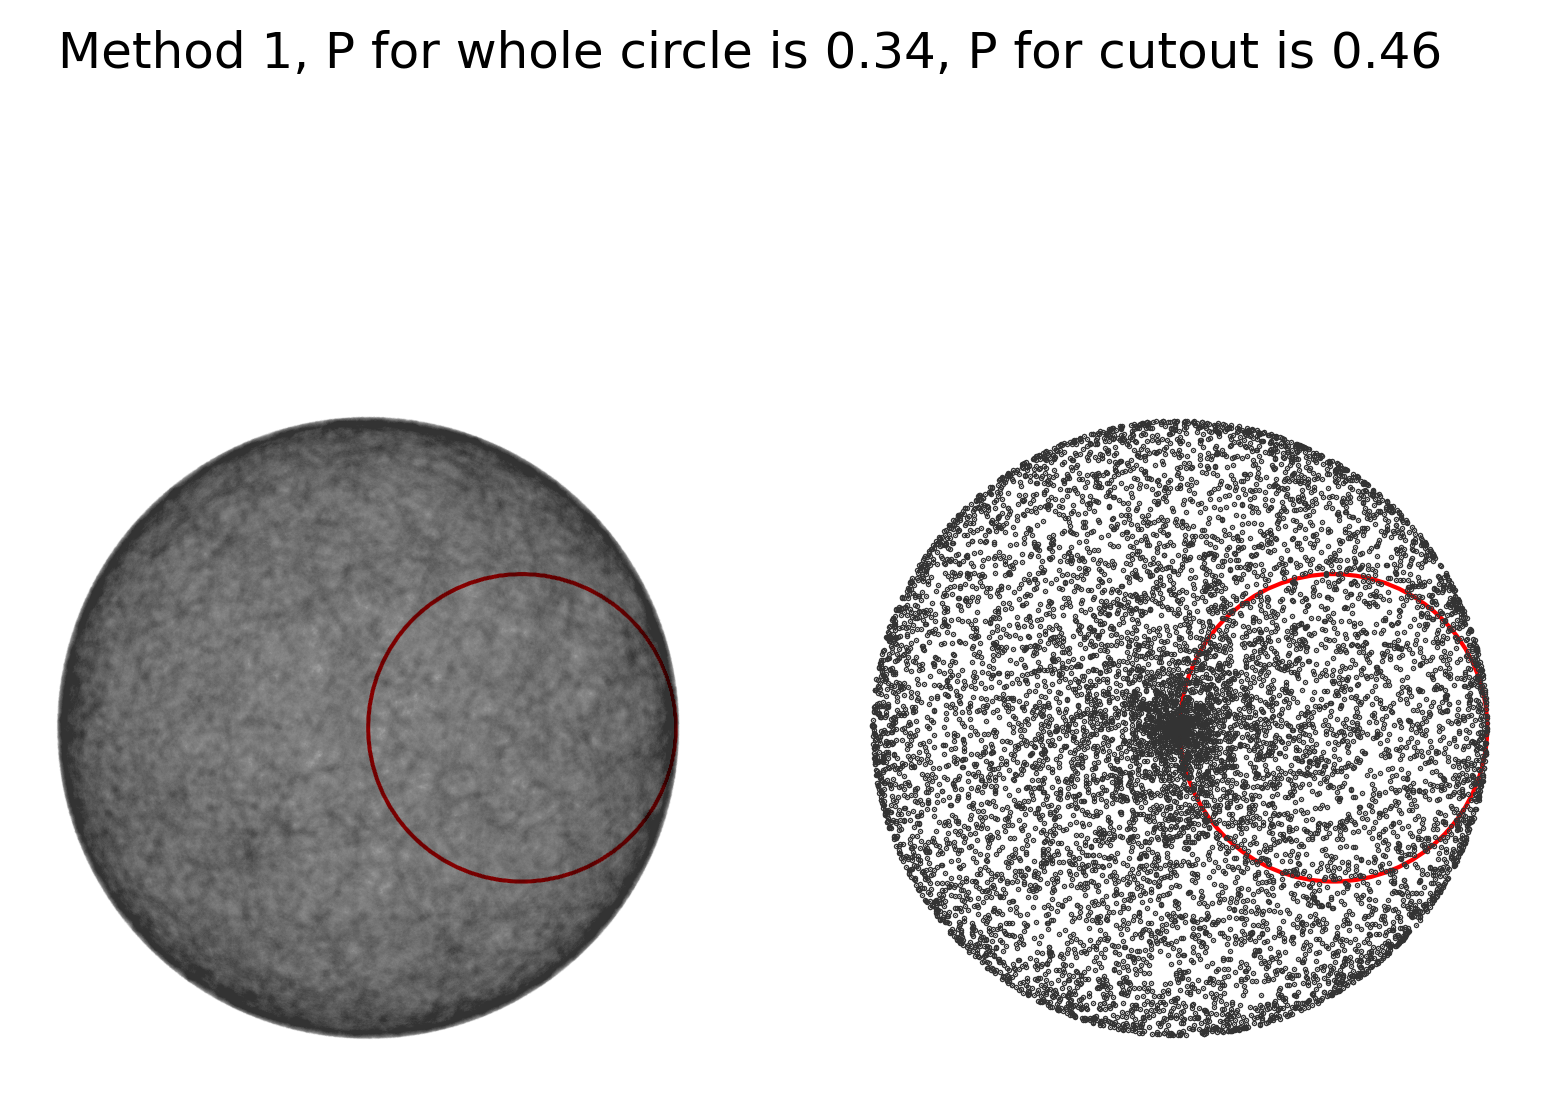

In [59]:
def generate_chords_m1(n = N_CHORDS):
    # generate uniformly distributed pairs of angles
    angles = np.random.random((n, 2)) * 2*np.pi 

    # convert to two points on a circle and swap axes so that each row represents a chord [[[x1, x2], [y1, y2]], ...]
    chords = np.array((R * np.cos(angles), R * np.sin(angles))) 
    chords = np.swapaxes(chords, 0, 1)

    # get middle points [[xdata], [ydata]]
    midpoints = np.mean(chords, axis=2).T
    
    return chords, midpoints

plot(*generate_chords_m1(), "Method 1")

This is not a correct solution. Chords are more densly packed near the circle edge and the probability for the cutout circle is greater than for whole circle


## Method 2

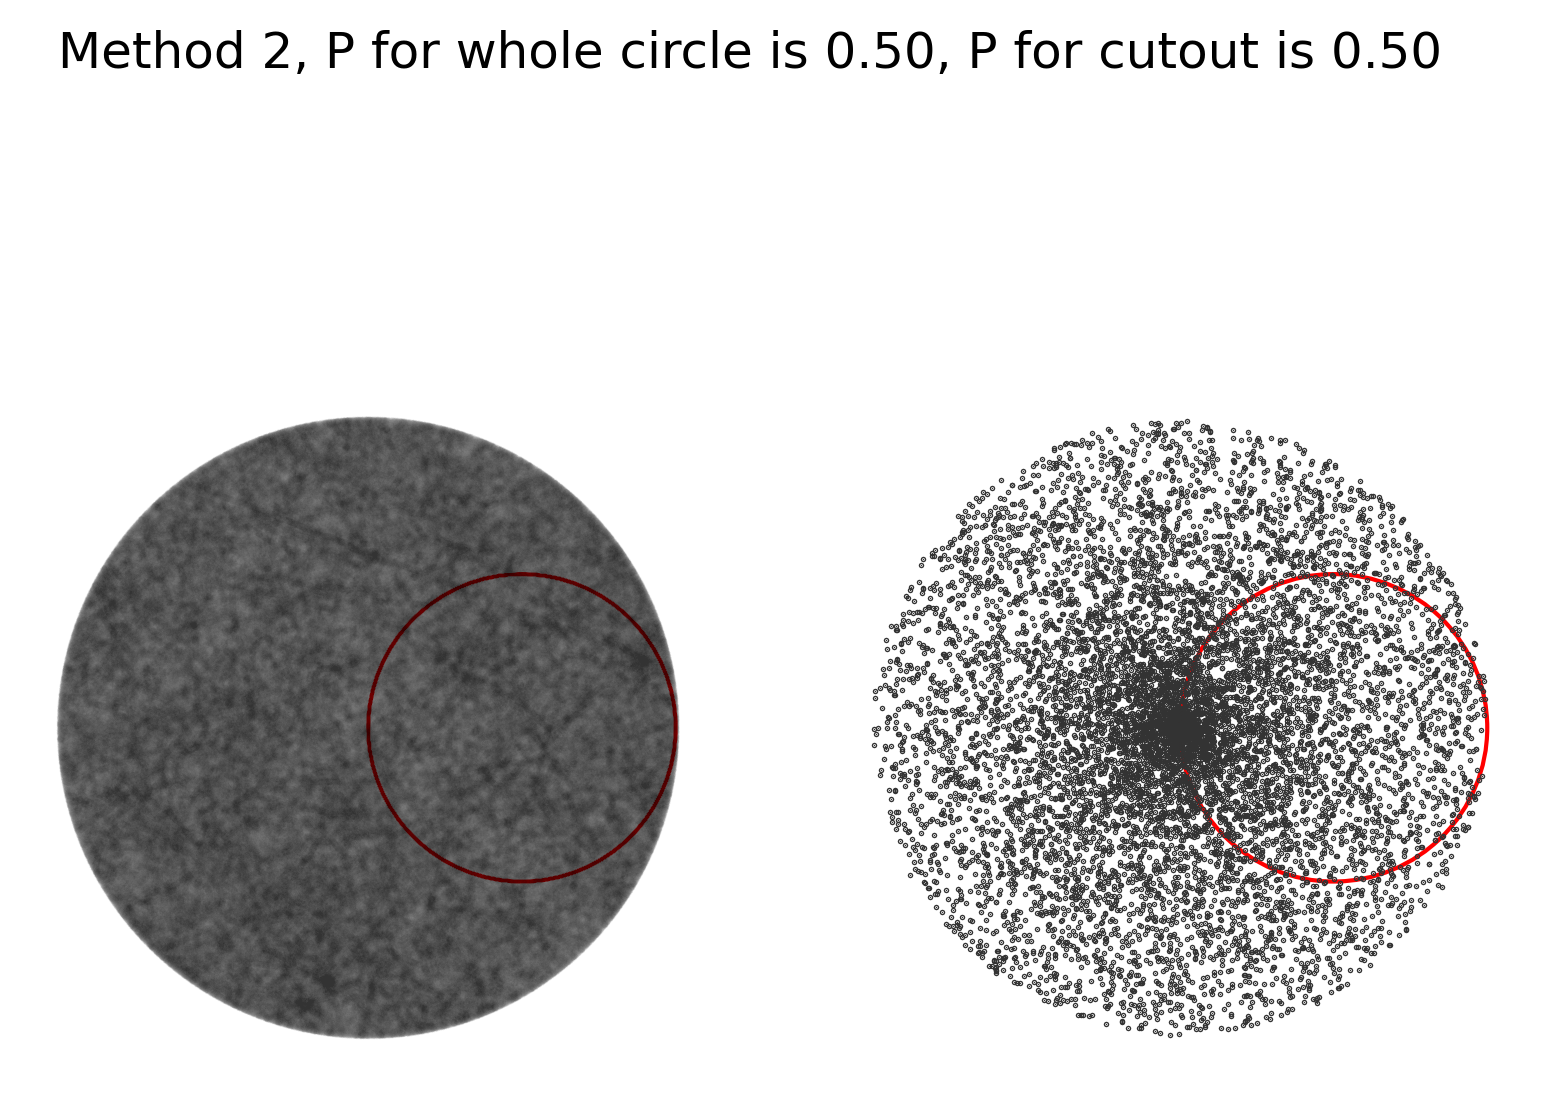

In [72]:
def generate_chords_m2(n = N_CHORDS):
    # generate uniformly distributed angles
    angles = np.random.random(n) * 2*np.pi

    # generate radii
    radii = np.random.random(n) * R

    # get middle positions
    midpoints = np.array([radii * np.cos(angles), radii * np.sin(angles)])

    # generate chords
    chords = np.zeros((n, 2, 2))
    for i, (x, y) in enumerate(midpoints.T):
        chords[i] = mid_to_chord(x, y)

    return chords, midpoints

plot(*generate_chords_m2(), "Method 2")

This method looks correct! Chords are evenly distributed around the circle and probabilities for the whole circle and for the cutout are the same.

## Method 3

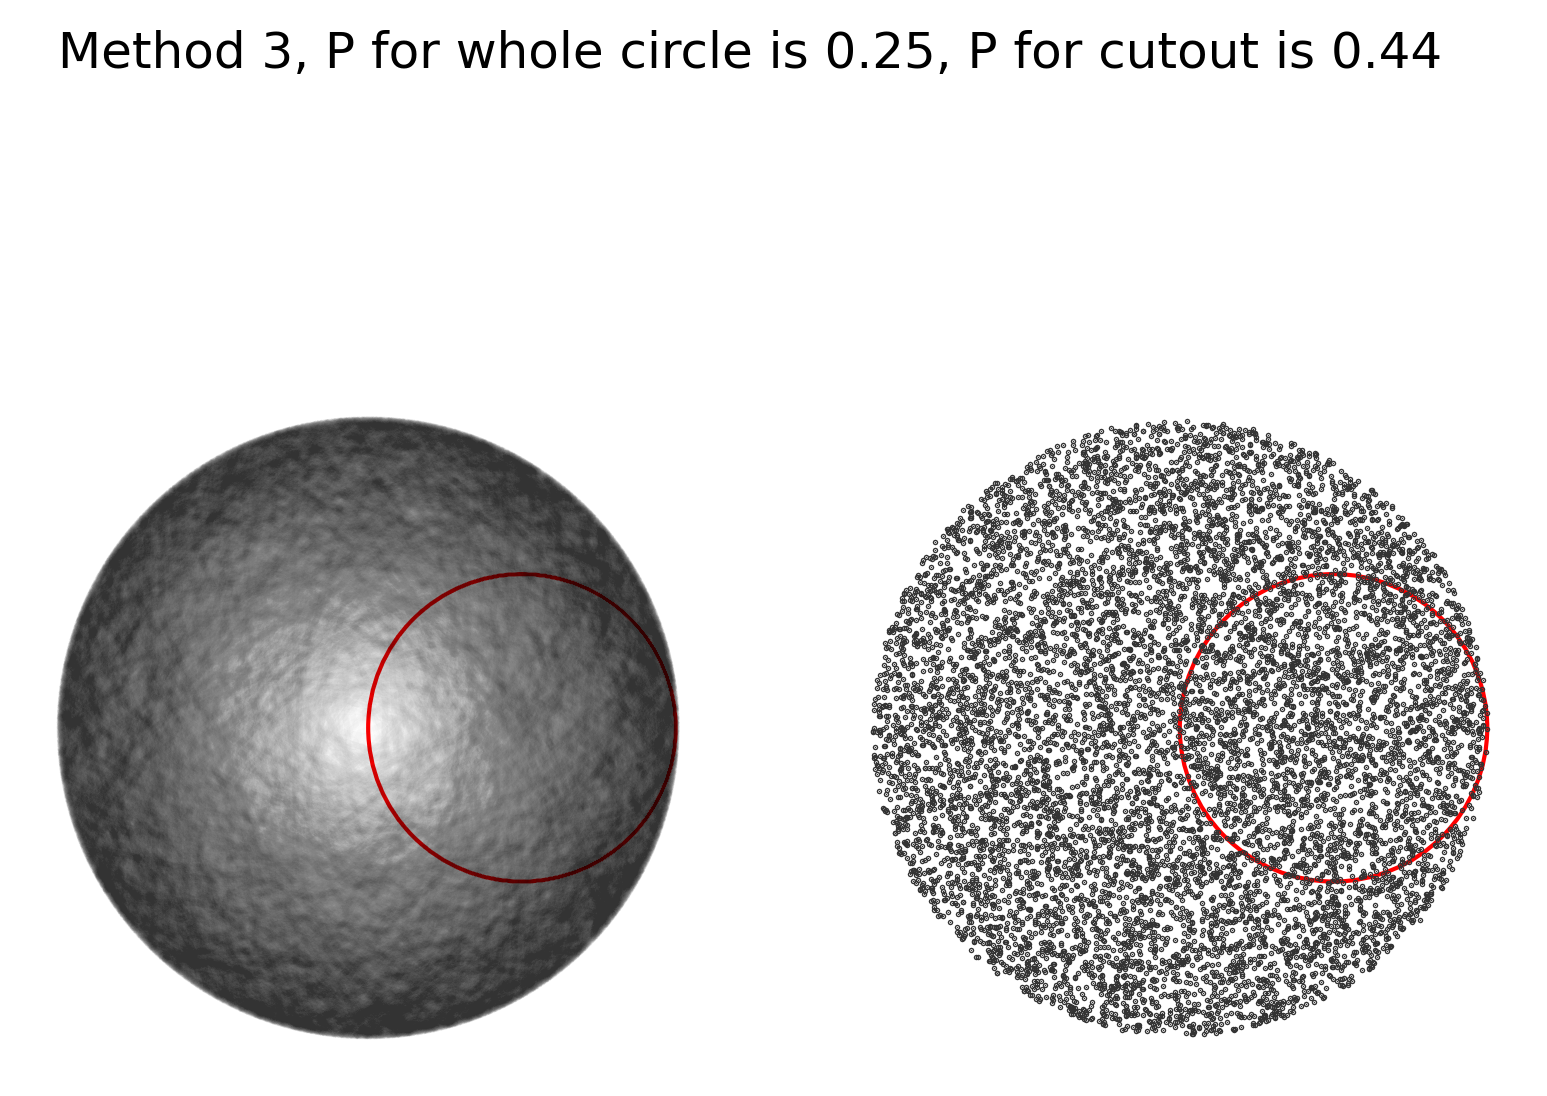

In [76]:
def generate_chords_m3(n=N_CHORDS):
    midpoints = []
    chords = []
    while len(chords) < n:
        # generate random point 
        x = np.random.uniform(-R, R)
        y = np.random.uniform(-R, R)

        # check if in the circle and convert midpoint to chord
        if x**2 + y**2 < R**2:
            midpoints.append([x, y])
            chords.append(mid_to_chord(x, y))

    return np.array(chords), np.array(midpoints).T

plot(*generate_chords_m3(), "Method 3")

This method is incorrect. Chords are distributed densly near the edge of the circle and thinly near the centre. Also probability for the cutout is higher than for the whole circle.

## Conclusion

Methods 1 and 3 are incorrect - their chord distributions are not uniformly covering the circle, resulting in different probability for the cutout circle. Only method 2 satisfies conditions for a correct solution - it produces a uniform distribution of chords and is invariant to scaling and translation.